In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"olgsmv","key":"c587511e01bd31ed37e0180c167b9f04"}'}

In [3]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d awsaf49/ecommerce-search-result-relevane-by-crowdflower
!unzip /content/ecommerce-search-result-relevane-by-crowdflower.zip

 81% 5.00M/6.15M [00:00<00:00, 35.6MB/s]
100% 6.15M/6.15M [00:00<00:00, 36.8MB/s]
Archive:  /content/ecommerce-search-result-relevane-by-crowdflower.zip
  inflating: kaggle_ecommerce_complete_Rank_Crowd_AGG_Descriptions_ALL_ROWS.csv  


In [5]:
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import warnings
import pandas as pd
import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import string
from sklearn.metrics import ndcg_score


torch.manual_seed(42)
np.random.seed(42)


warnings.filterwarnings('ignore')

if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"

%matplotlib inline

In [6]:
dev

'cuda:0'

We will take commerce marketplace dataset - ranked products based on some hidden business logic for a given query.

In [7]:
df = pd.read_csv('kaggle_ecommerce_complete_Rank_Crowd_AGG_Descriptions_ALL_ROWS.csv', sep=',', encoding='latin-1')
df = df[['query', 'product_title', 'product_description','relevance', 'product_price','rank']]
query2doc_amount = df.groupby('query')['product_title'].count().to_dict()
df['docs_amount'] = df['query'].apply(lambda x: query2doc_amount[x])
df = df[(df['docs_amount']>= 10)]
df['relevance'].fillna(0, inplace=True)
df = df.drop_duplicates(['query', 'product_title', 'relevance'], keep='first')
df.head()

,query,product_title,product_description,relevance,product_price,rank,docs_amount
0,playstation 4,Sony PlayStation 4 (PS4) (Latest Model)- 500 G...,The PlayStation 4 system opens the door to an ...,3.67,$329.98,1,179
1,playstation 4,Sony PlayStation 4 (Latest Model)- 500 GB Jet ...,The PlayStation 4 system opens the door to an ...,4.00,$324.84,2,179
2,playstation 4,Sony PlayStation 4 PS4 500 GB Jet Black Console,The PlayStation 4 system opens the door to an ...,4.00,$324.83,3,179
3,playstation 4,Sony - PlayStation 4 500GB The Last of Us Rema...,NaN,3.67,$350.00,4,179
4,playstation 4,Sony PlayStation 4 (PS4) (Latest Model)- 500 G...,The PlayStation 4 system opens the door to an ...,3.33,$308.00\nTrending at\n$319.99,5,179


In [8]:
df[df['query'] == 'minecraft diamond sword'].sort_values('relevance', ascending=False).head(10)

,query,product_title,product_description,relevance,product_price,rank,docs_amount
13483,minecraft diamond sword,Minecraft Foam Diamond Sword,Surprise your favorite little Minecraft fan wi...,4.00,$19.99,1,26
16905,minecraft diamond sword,Minecraft Foam Diamond Sword (Each),Go Minecraft crazy when you bring home this Mi...,4.00,$22.99,1,26
16906,minecraft diamond sword,The Quest for the Diamond Sword: A Minecraft G...,After discovering that zombies have destroyed ...,3.33,$7.99,2,26
8284,minecraft diamond sword,Minecraft Diamond Sword Metal Keychain,"*1"" scale keychain, *Real heavy duty metal con...",3.00,$10.99,1,26
8285,minecraft diamond sword,The Quest for the Diamond Sword : A Minecraft ...,The Quest for the Diamond Sword : A Minecraft ...,3.00,Sale $7.99,2,26
8289,minecraft diamond sword,Justice-Girls Minecraft Foam Diamond Sword -Mu...,"You may be thinking, ""ThinkGeek, what took you...",3.00,$19.99,6,26
8288,minecraft diamond sword,Minecraft Diamond Steve Vinyl 6,"*6"" Tall Vinyl Diamond Steve Figure, *Comes Wi...",2.75,$26.99,5,26
13484,minecraft diamond sword,Minecraft Foam Diamond Pickaxe,Your favorite Minecraft fan will really dig th...,2.67,$19.99,2,26
16907,minecraft diamond sword,Minecraft Foam Diamond Pickaxe (Each),Building has become your life ever since you g...,2.67,$19.99,3,26
8286,minecraft diamond sword,En busca de la espada de diamante / In search ...,Steve se dedica a cultivar trigo e intercambia...,2.33,$6.95,3,26


In [9]:
query2doc_dict = df.groupby('query')[['product_title', 'relevance']].agg(list).to_dict()

In [10]:
punctuation_set = set(string.punctuation + '«»—')

def clean_punctuation(input_text) -> str:
    input_text = input_text.split('.')[0]
    space = " "
    cleaned_string = "".join([c if c not in punctuation_set else space for c in input_text])
    cleaned_string = space.join(cleaned_string.split()).lower()
    return cleaned_string

In [11]:
TOP_N = 10
queries_list = list(query2doc_dict['product_title'].keys())
training_dict = dict()
for query in queries_list:
  preprocessed_query = clean_punctuation(query)
  relevance_scores_sorted_idx = np.argsort(np.array(query2doc_dict['relevance'][query]))[-TOP_N:]
  docs_list = np.array(query2doc_dict['product_title'][query])[relevance_scores_sorted_idx]
  preprocessed_docs_list = [clean_punctuation(doc) for doc in list(docs_list)]
  relevance_rank  = [i for i in range(1, len(preprocessed_docs_list) + 1)]
  training_dict[preprocessed_query] = {'docs': preprocessed_docs_list, 'scores': relevance_rank}

print('Example instance: ', training_dict['minecraft diamond sword'])
print('Total samples: ', len(training_dict))

Example instance:  {'docs': ['en busca de la espada de diamante in search of the diamond sword una increå¥ìû ble aventura de minecraft an amazing adventure of minecraft paperback', 'minecraft foam diamond pickaxe', 'minecraft foam diamond pickaxe each', 'minecraft diamond steve vinyl 6', 'justice girls minecraft foam diamond sword multi size no size', 'the quest for the diamond sword a minecraft gamer s adventure paperback', 'minecraft diamond sword metal keychain', 'the quest for the diamond sword a minecraft gamer s adventure', 'minecraft foam diamond sword each', 'minecraft foam diamond sword'], 'scores': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
Total samples:  261


In [12]:
MAX_LEN = 0
query_str_list, doc_str_list = [], []
for q in training_dict:
  for d in training_dict[q]['docs']:
    if len(d.split()) > MAX_LEN:
      MAX_LEN = len(d.split())
    doc_str_list.append(d)
  query_str_list.append(q)
print(MAX_LEN)

len(doc_str_list), len(query_str_list)

41


(2610, 261)

In [13]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def yield_tokens(query_list, doc_list):
    for q in query_list:
      yield tokenizer(query)
    for d in doc_list:
      yield tokenizer(d)

vocab = build_vocab_from_iterator(yield_tokens(query_str_list, doc_str_list), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

Dataset will be in the following manner - query, docs list and labels distribution(low label - low relevance).

In [14]:
from torch.utils.data import Dataset, DataLoader

text_pipeline = lambda x: vocab(tokenizer(x))

class QueryDocDataset(Dataset):
  def __init__(self, query2doc_dict):
    self.query2doc_dict = query2doc_dict
    self.query_list = list(self.query2doc_dict.keys())

  def __len__(self):
    return len(self.query_list)

  def __getitem__(self, idx):

      selected_query = self.query_list[idx]
      label_list = self.query2doc_dict[selected_query]['scores']
      docs_list = self.query2doc_dict[selected_query]['docs']
      query_ids = torch.tensor(text_pipeline(selected_query))
      query_padding_len = MAX_LEN - len(query_ids)
      query_ids_padded = torch.nn.functional.pad(query_ids, (0, query_padding_len), "constant", 0).to(dev)

      doc_list_of_ids = list(map(text_pipeline, docs_list))
      doc_ids_list = []
      for doc_id_list in doc_list_of_ids:
        doc_padding_len = MAX_LEN - len(doc_id_list)
        doc_ids_padded = torch.nn.functional.pad(torch.tensor(doc_id_list), (0, doc_padding_len), "constant", 0)
        doc_ids_list.append(doc_ids_padded)
      doc_ids_list_tensor = torch.vstack(doc_ids_list).to(dev).long().to(dev)

      label_tensor = torch.FloatTensor(label_list).to(dev)

      return query_ids_padded, doc_ids_list_tensor, label_tensor

def test():
  query_doc_dataset = QueryDocDataset(training_dict)
  return query_doc_dataset[0]

test()

(tensor([107, 217,  59, 139,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        device='cuda:0'),
 tensor([[1210, 1087,  185,  685, 1465,  101,  397,   59,  139,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0],
         [1210, 1087,  185,  685, 4840,   59,  139,  458,   29,  238,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0],
         [2930, 3954, 1326,  185, 1980,  458,   32,   59,  139,   12,   89, 1463,
           267,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
   

In [15]:
def cross_entropy(input, target):
    return -torch.sum(target * torch.log(input))

y = torch.Tensor([[0.2, 0.3, 0.5]])
yhat = torch.Tensor([[0.5, 0.3, 0.2]])
print(cross_entropy(y, yhat))

tensor(1.3045)


In [17]:
class ListNetModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden1):
        super(ListNetModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim*2, hidden1)
        self.fc2 = nn.Linear(hidden1, 1)
        self.softmax = nn.Softmax(dim=0)
        self.init_weights()

  def init_weights(self):
      initrange = 0.5
      self.embedding.weight.data.uniform_(-initrange, initrange)
      self.fc1.weight.data.uniform_(-initrange, initrange)
      self.fc1.bias.data.zero_()

      self.fc2.weight.data.uniform_(-initrange, initrange)
      self.fc2.bias.data.zero_()

  def forward(self, query, doc_list):
      query_embedding_vector = self.embedding(query).mean(dim=0).expand(len(doc_list), -1)
      doc_embedding_matrix = self.embedding(doc_list).mean(dim=1)
      feature_vec = torch.cat([query_embedding_vector, doc_embedding_matrix], dim=-1)
      fc1 = self.fc1(feature_vec)
      fc2 = self.fc2(fc1)
      distr = self.softmax(fc2).view(1,-1).flatten()
      return distr

def test():
  query_doc_dataset = QueryDocDataset(training_dict)
  query_vec, doc_matrix, labels = query_doc_dataset[0]
  print(query_vec, doc_matrix)
  print(labels)
  list_net_model = ListNetModel(len(vocab), 2, 4).to(dev)
  predicted_distr = list_net_model.forward(query_vec, doc_matrix)
  print(predicted_distr)
  true_distr = list_net_model.softmax(labels)
  print(true_distr)
  optimizer = optim.Adam(list_net_model.parameters(), lr=0.1)
  loss = cross_entropy(predicted_distr, true_distr)
  print('Loss: ', loss)

test()

tensor([107, 217,  59, 139,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       device='cuda:0') tensor([[1210, 1087,  185,  685, 1465,  101,  397,   59,  139,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [1210, 1087,  185,  685, 4840,   59,  139,  458,   29,  238,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0],
        [2930, 3954, 1326,  185, 1980,  458,   32,   59,  139,   12,   89, 1463,
          267,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    

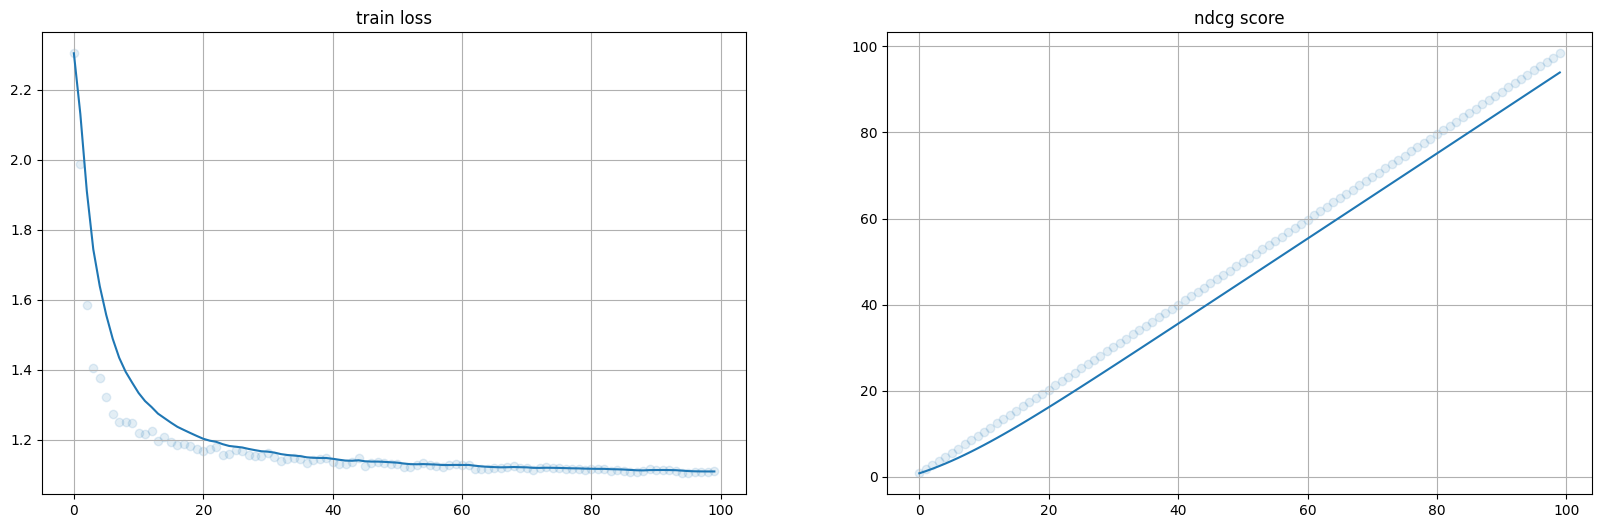

Epoch number = 99, ndcg = 98.37676671736715


In [21]:
EPOCH_NUM = 100

ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

ranking_dataset = QueryDocDataset(training_dict)

list_net_model = ListNetModel(len(vocab), 2, 4).to(dev)
optimizer = optim.Adam(list_net_model.parameters(), lr=0.03)

loss_array, ndcg_array  = [], []
ndcg_epoch_score= 0
for epoch in range(EPOCH_NUM):
  epoch_avg_loss = 0
  for sample in ranking_dataset:
    query_vec, doc_matrix, labels = sample
    true_distrib = list_net_model.softmax(labels)
    optimizer.zero_grad()
    predicted_distr = list_net_model.forward(query_vec, doc_matrix)
    loss = cross_entropy(predicted_distr, true_distrib)
    loss.backward()
    optimizer.step()

    epoch_avg_loss += loss.item()

    labels = labels.detach().cpu().numpy().astype(int).reshape(1,-1)
    predicted_distr = predicted_distr.detach().cpu().numpy().reshape(1,-1)
    ndcg_val = ndcg_score(labels, predicted_distr)
    ndcg_epoch_score += ndcg_val

  loss_array.append(epoch_avg_loss / len(ranking_dataset))
  ndcg_array.append(ndcg_epoch_score / len(ranking_dataset))

  clear_output(True)
  plt.figure(figsize=[20, 6])
  plt.subplot(1, 2, 1), plt.title('train loss'), plt.grid()
  plt.scatter(np.arange(len(loss_array)), loss_array, alpha=0.12)
  plt.plot(ewma(loss_array, span=10))

  plt.subplot(1, 2, 2), plt.title('ndcg score'), plt.grid()
  plt.scatter(np.arange(len(ndcg_array)), ndcg_array, alpha=0.12)
  plt.plot(ewma(ndcg_array, span=10))

  plt.show()

  print('Epoch number = {0}, ndcg = {1}'.format(epoch, ndcg_array[-1]))

Lets visualize predicted distribution. For sake of visualization we will take negative log of softmax distribution.

In [26]:
labels

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.], device='cuda:0')

True ranking: 
Doc@0:  minecraft foam diamond sword 0.6321493
Doc@1:  minecraft foam diamond sword each 0.23255473
Doc@2:  the quest for the diamond sword a minecraft gamer s adventure 0.0855521
Doc@3:  minecraft diamond sword metal keychain 0.031472858
Doc@4:  the quest for the diamond sword a minecraft gamer s adventure paperback 0.011578218
Doc@5:  justice girls minecraft foam diamond sword multi size no size 0.004259388
Doc@6:  minecraft diamond steve vinyl 6 0.0015669414
Doc@7:  minecraft foam diamond pickaxe each 0.0005764455
Doc@8:  minecraft foam diamond pickaxe 0.00021206246
Doc@9:  en busca de la espada de diamante in search of the diamond sword una increå¥ìû ble aventura de minecraft an amazing adventure of minecraft paperback 7.8013414e-05

Predicted ranking: 
Doc@0:  minecraft foam diamond sword 0.60306543
Doc@1:  minecraft foam diamond sword each 0.25121102
Doc@2:  the quest for the diamond sword a minecraft gamer s adventure 0.07577792
Doc@3:  minecraft diamond sword met

Text(0, 0.5, 'proba')

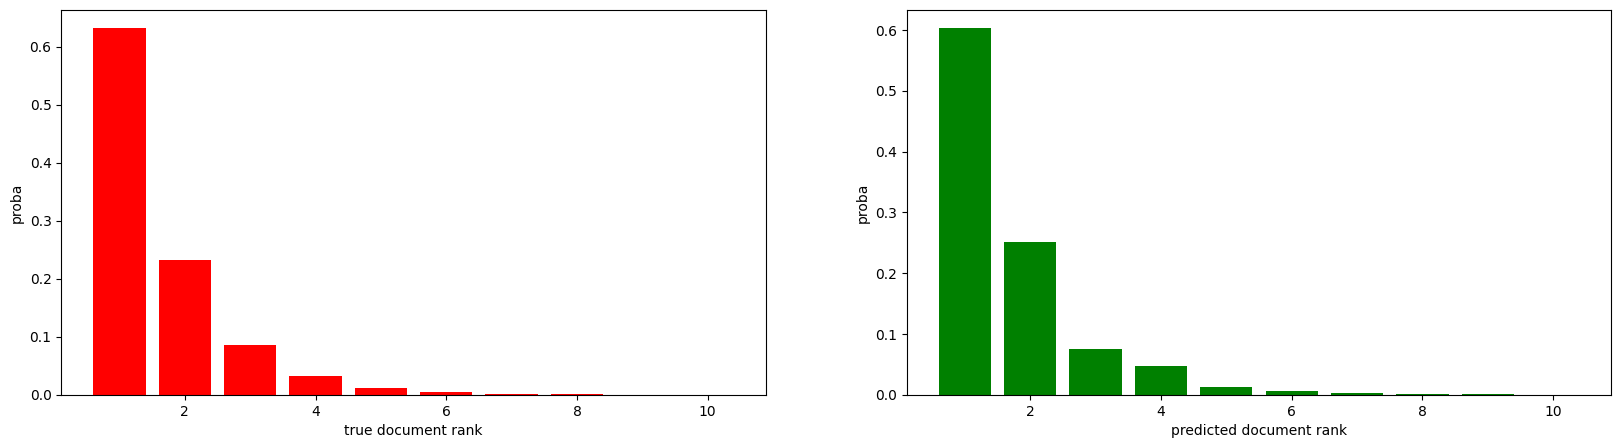

In [27]:
example_sample = 'minecraft diamond sword'
print('True ranking: ')

docs_list = training_dict[example_sample]['docs']
example_sample_idx = list(training_dict.keys()).index(example_sample)
query_vec, doc_matrix, labels = ranking_dataset[example_sample_idx]

true_distrib = list_net_model.softmax(labels)
true_distrib = true_distrib.cpu().numpy()
for idx, doc in enumerate(zip(reversed(docs_list), reversed(true_distrib))):
  doc, score = doc
  print(f'Doc@{idx}: ', doc, score)

predicted_distr = list_net_model.forward(query_vec, doc_matrix).detach().cpu().numpy()
#сортируем значения предсказаний от меньшего к большему
sorted_distr_idx = np.array(list(reversed(np.argsort(predicted_distr))))
predicted_docs = np.array(docs_list)[sorted_distr_idx]
predicted_scores = predicted_distr[sorted_distr_idx]


print()
print('Predicted ranking: ')
for idx, doc in enumerate(zip(predicted_docs, predicted_scores)):
  doc, score = doc
  print(f'Doc@{idx}: ', doc, score)

plt.figure(figsize=[20, 5])
plt.subplot(1, 2, 1)
# так как работаем изначально - labels состоит из объектов от 0(наименее релевантный) к 1(наиболее релевантный) - перевернем список
labels = labels.cpu().numpy()
plt.bar(labels, list(reversed(true_distrib)), color='r')
plt.xlabel('true document rank')
plt.ylabel('proba')

plt.subplot(1, 2, 2)
plt.bar(labels, predicted_scores, color='g')
plt.xlabel('predicted document rank')
plt.ylabel('proba')

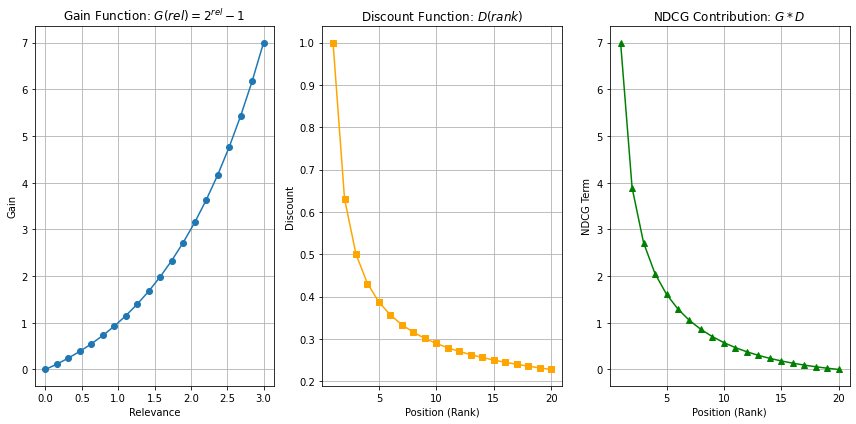

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define positions (ranks)
positions = np.arange(1, 21)

# Gain function: G(rel) = 2^rel - 1 (assume relevance = 3 for top doc, linearly decreasing)
# We'll simulate relevance levels decreasing linearly from 3 to 0
relevance = np.linspace(3, 0, len(positions))
gain = 2**relevance - 1

# Discount function: D(rank) = log2(rank + 1)
discount = 1 / np.log2(positions + 1)

# NDCG contribution at each position
ndcg_contrib = gain * discount

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(relevance, gain, marker='o')
plt.title("Gain Function: $G(rel) = 2^{rel} - 1$")
plt.xlabel("Relevance")
plt.ylabel("Gain")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(positions, discount, marker='s', color='orange')
plt.title("Discount Function: $D(rank)$")
plt.xlabel("Position (Rank)")
plt.ylabel("Discount")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(positions, ndcg_contrib, marker='^', color='green')
plt.title("NDCG Contribution: $G*D$")
plt.xlabel("Position (Rank)")
plt.ylabel("NDCG Term")
plt.grid(True)

plt.tight_layout()
plt.show()
